In [1]:
library(tidyverse)
library(modelr)

# forces some modelling functions to warn if they drop missing values
options(na.action = na.warn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



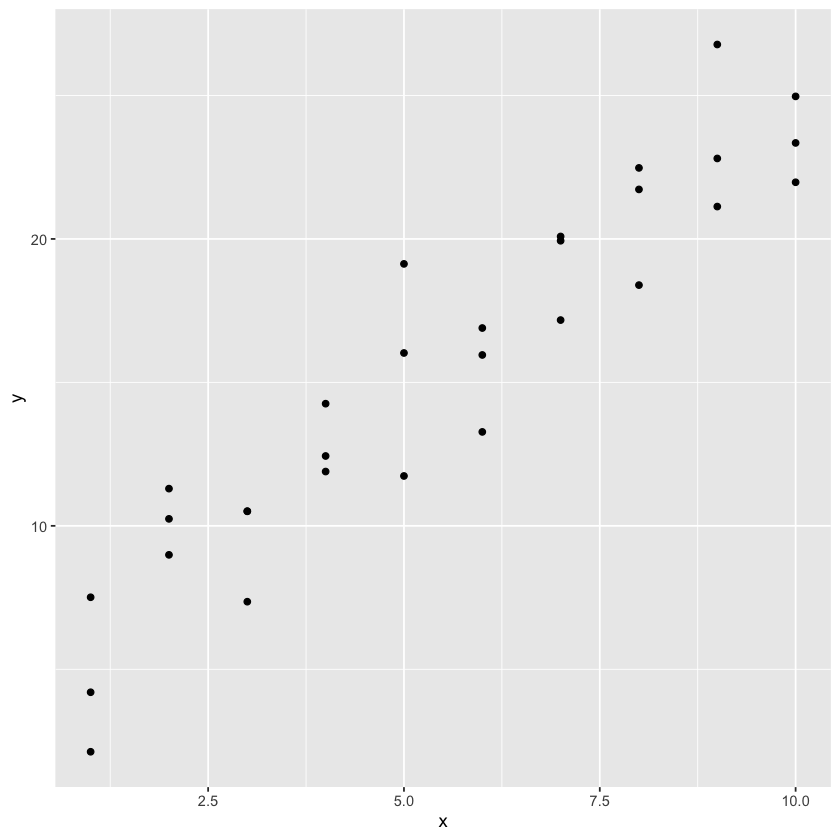

In [2]:
ggplot(sim1, aes(x, y)) + geom_point()

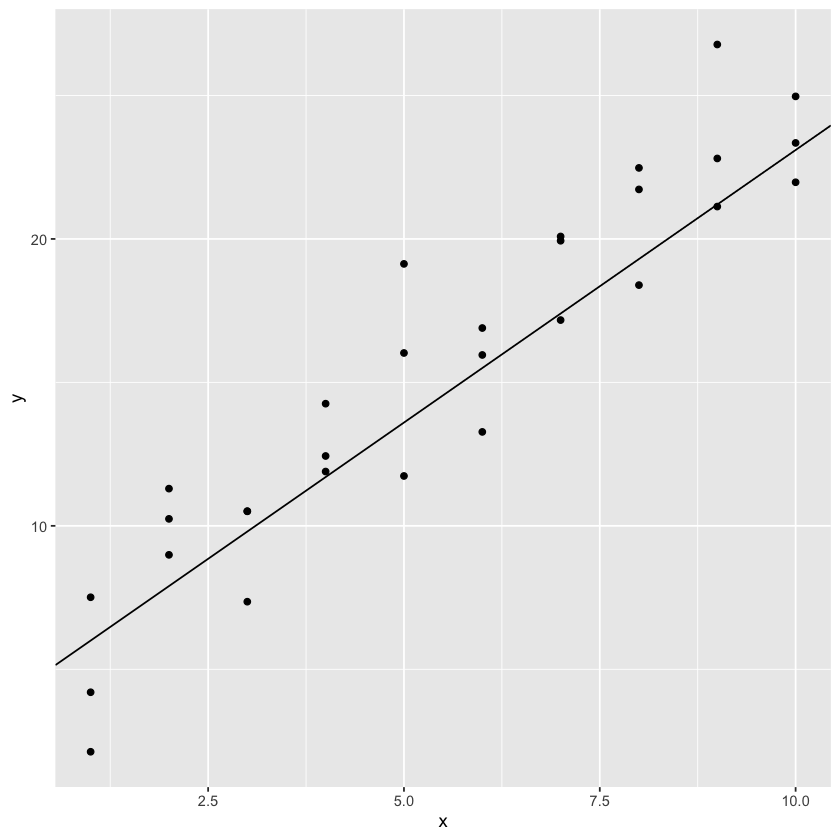

In [6]:
a1 <- 4.1005
a2 <- 1.9

ggplot(sim1) +
    geom_point(aes(x,y)) +
    geom_abline(aes(intercept=a1, slope=a2))

<img src="https://d33wubrfki0l68.cloudfront.net/f7369534ecf1c3178c2effa3837c0fd1bfc0b6c6/8be3a/model-basics_files/figure-html/unnamed-chunk-3-1.png" width="500" height="500" />

Let's write a function to evaluate a linear model: Root Mean Squared Error (RMSE)
1. Get the model predictions.
2. Find the squared difference between each prediction and each "true" y-value.
3. Take the square root of the mean of these differences.

Hint: You don't have to use a for loop!

In [8]:
# "a" is a numeric vector of length 2
# a <- c(4, 2)
# a[1] = 4, a[2] = 2
# data is a tibble with an x column and a y column
RMSE <- function(a, data) {
    pred <- a[1] + a[2] * data$x
    diff <- pred - data$y
    sq_diff <- diff^2
    sqrt(mean(sq_diff))
}

[1] "Root Mean Squared Error:"
[1] 2.192107


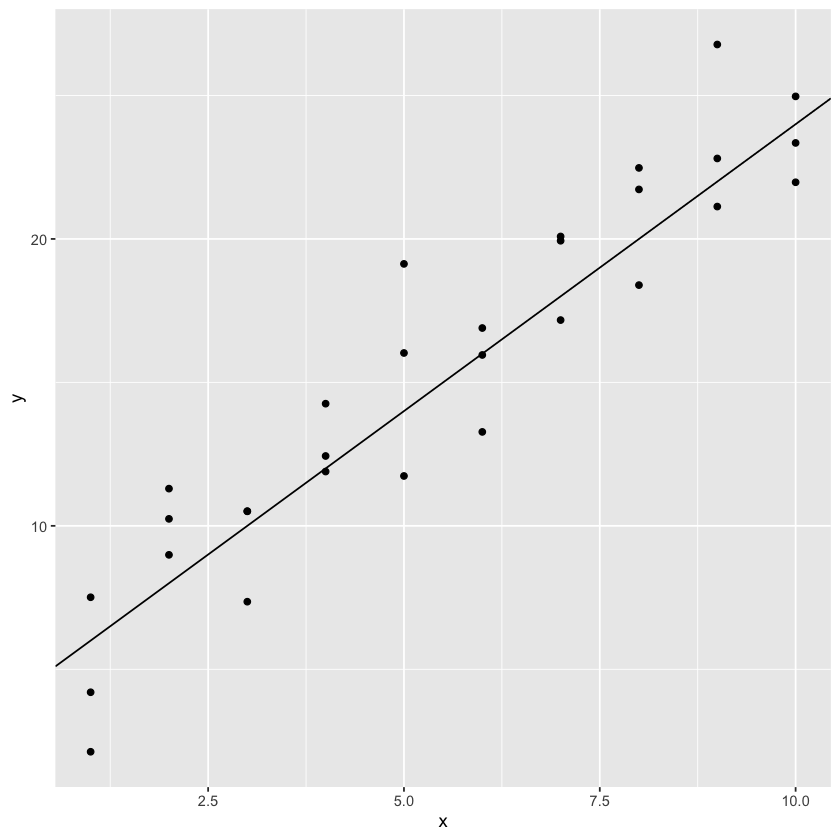

In [13]:
a1 <- 4
a2 <- 2
print('Root Mean Squared Error:')
print(RMSE(c(a1,a2), sim1))

ggplot(sim1) +
    geom_point(aes(x,y)) +
    geom_abline(aes(intercept=a1, slope=a2))

Let's choose ten possible models and then graph them, using their RMSE as an aesthetic

In [14]:
v1 <- c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
v2 <- c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

# computes RMSE on sim1 dataset
sim1_RMSE <- function(a1, a2) {
    RMSE(c(a1, a2), sim1)
}

# map2_dbl applies a function with two vectors/lists as arguments
models <- tibble(a1 = v1, a2 = v2) %>%
    mutate(Error = map2_dbl(a1, a2, sim1_RMSE)) %>%
    print()

# A tibble: 10 x 3
      a1    a2 Error
   <dbl> <dbl> <dbl>
 1     1     1  9.73
 2     2     2  3.29
 3     3     3  5.28
 4     4     4 12.1 
 5     5     5 19.1 
 6     6     6 26.2 
 7     7     7 33.3 
 8     8     8 40.4 
 9     9     9 47.4 
10    10    10 54.5 


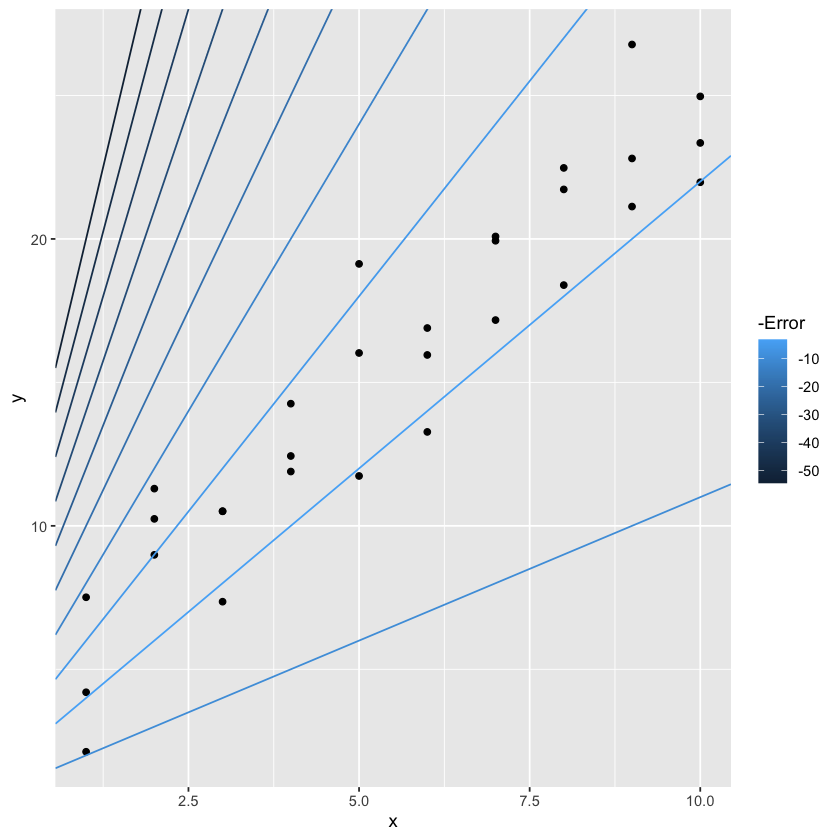

In [15]:
ggplot() +
    geom_point(data = sim1, aes(x,y)) +    # the data
    geom_abline(data = models, aes(intercept = a1, slope = a2, color = -Error))   # the models

To try to find the best parameters for the *family of models* we can use a **grid search**.

# A tibble: 25 x 2
       a1    a2
    <dbl> <dbl>
 1 -5      1   
 2 -3.96   1.08
 3 -2.92   1.17
 4 -1.88   1.25
 5 -0.833  1.33
 6  0.208  1.42
 7  1.25   1.5 
 8  2.29   1.58
 9  3.33   1.67
10  4.38   1.75
# … with 15 more rows
# A tibble: 625 x 2
      a1    a2
   <dbl> <dbl>
 1    -5  1   
 2    -5  1.08
 3    -5  1.17
 4    -5  1.25
 5    -5  1.33
 6    -5  1.42
 7    -5  1.5 
 8    -5  1.58
 9    -5  1.67
10    -5  1.75
# … with 615 more rows
# A tibble: 625 x 3
      a1    a2 Error
   <dbl> <dbl> <dbl>
 1    -5  1     15.5
 2    -5  1.08  15.0
 3    -5  1.17  14.5
 4    -5  1.25  14.0
 5    -5  1.33  13.5
 6    -5  1.42  13.0
 7    -5  1.5   12.5
 8    -5  1.58  12.1
 9    -5  1.67  11.6
10    -5  1.75  11.1
# … with 615 more rows


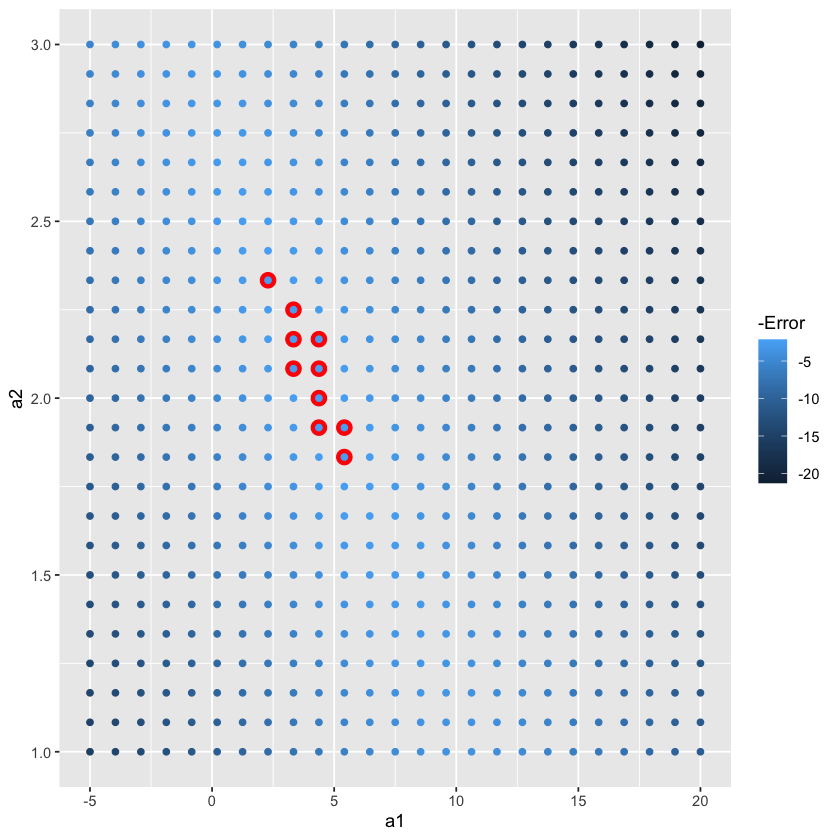

In [22]:
# create a vector between 1 and 5 of length 20
v1 <- seq(-5, 20, length = 25)
v2 <- seq(1, 3, length = 25)

models_grid <- tibble(a1 = v1, a2 = v2) %T>%
    print() %>%
    complete(a1, a2) %T>%    # this adds a row for each combination of a1, a2
    print() %>%
    mutate(Error = map2_dbl(a1, a2, sim1_RMSE)) %>%
    print()

ggplot() +
    geom_point(data = filter(models_grid, rank(Error) <= 10), aes(a1, a2), size = 4, color = "red") +
    geom_point(data = models_grid, aes(a1, a2, color = -Error))

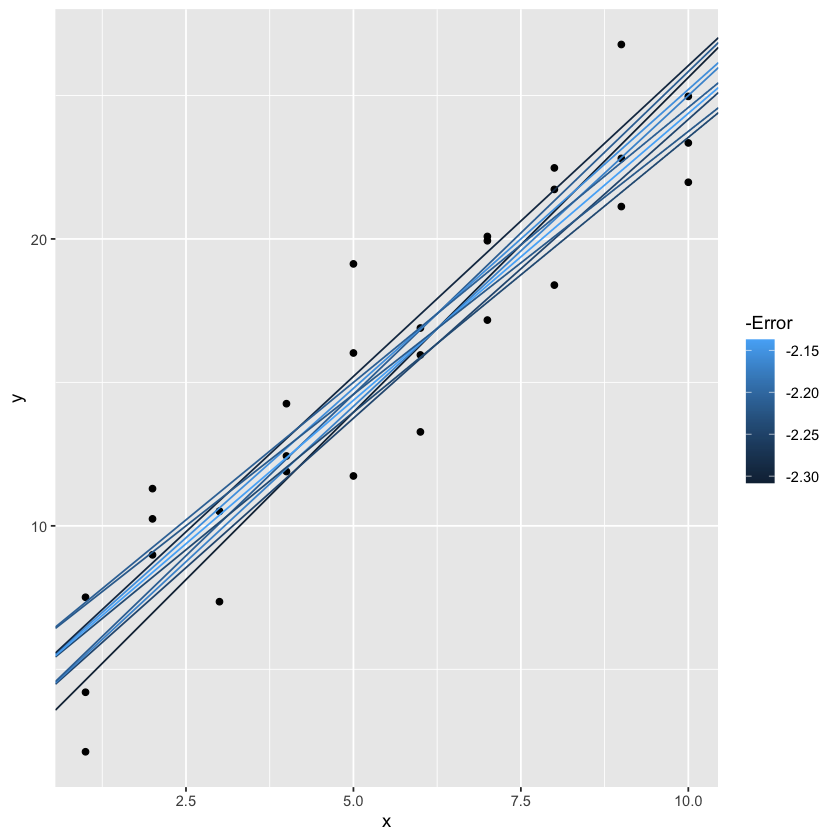

In [23]:
ggplot() +
    geom_point(data = sim1, aes(x,y)) +    # the data
    geom_abline(data = filter(models_grid, rank(Error) <= 10),
                aes(intercept = a1, slope = a2, color = -Error))   # the models

The specific pair of values that give the lowest RMSE represents our *fitted model*.
- The function ```optim``` finds the approximate best (according to our error function) parameters for our model.
- This is computed *iteratively* so the first argument is the starting point
- The second argument is the function to minimize
- We also have to pass any additional arguments of the function we are minimizing to ```optim```
 * For example, below ```data=``` is an argument of RMSE
- Next week we'll learn that here RMSE is an example of a *loss function*

In [26]:
best <- optim(c(0, 0), RMSE, data = sim1)
#best    # best is a list with additional meta-data

# the optimal linear model is
best$par

# the lowest RMSE (which is achieved by the optimal linear model) is
best$value

[1] 4.222248 2.051204

[1] 2.128181

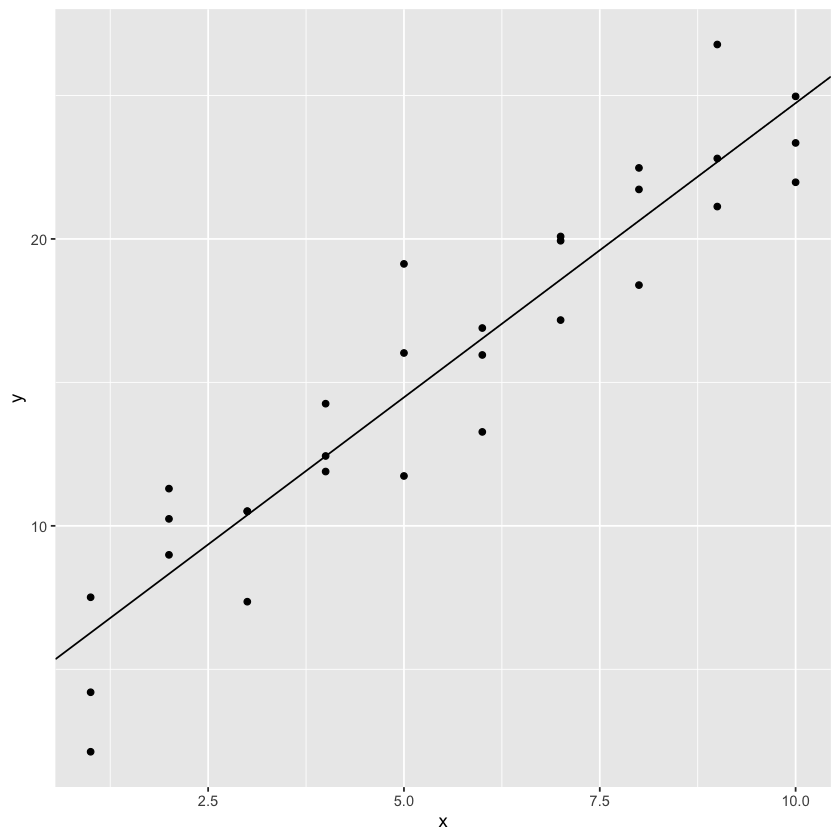

In [27]:
a <- best$par
ggplot() +
    geom_point(data = sim1, aes(x,y)) +    # the data
    geom_abline(aes(intercept = a[1], slope = a[2]))

Attempt:
- Try fitting a linear model to the data using a different metric or a different starting point.
- Do you get the same result? Why or why not?

In [32]:
best <- optim(c(1, 0), RMSE, data = sim1)
best$par
best$value

[1] 4.219393 2.051742

[1] 2.128181

In [41]:
new_metric <- function(a, data) {
    pred <- a[1] + a[2] * data$x
    diff <- pred - data$y
    abs_diff <- abs(diff)
    sd(abs_diff)
}
best <- optim(c(0, 0), new_metric, data = sim1)
best$par
best$value

[1] 3.116953 2.229946

[1] 1.211126

In [39]:
sd(sim1$x)

[1] 2.921384